<a href="https://colab.research.google.com/github/cluePrints/fastai-v3-notes/blob/master/fastai3_part2_06_cuda_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [234]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
def sorta_import(name):
  import urllib.request
  import os
  a = urllib.request.urlopen(f'https://raw.githubusercontent.com/fastai/fastai_docs/master/dev_course/dl2/exp/{name}.py')
  os.makedirs('exp', exist_ok=True)
  with open(f'exp/{name}.py', 'wb') as f:
    f.write(a.read())
  __import__(f'exp.{name}')

def load_modules_up_to(n_inclusive):
  for i in range(n_inclusive + 1):
    try:
      sorta_import(f'nb_0{i}')
    except:
      print(f"Problem importing {i}")
      raise

load_modules_up_to(5)
sorta_import('nb_05b')
from exp.nb_05b import *

In [0]:
x_train,y_train,x_valid,y_valid = get_data()

In [0]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from fastai.layers import Lambda

In [238]:
x_train[:100][:,None,...].shape

torch.Size([100, 1, 784])

In [0]:
n_classes = len(y_train.unique())
def one_hot(y, n_classes):
  emb = nn.Embedding(n_classes, n_classes) 
  emb.weight.data = torch.eye(n_classes)
  # Note to self: otherwise fail later with "the derivative for 'target' is not implemented"
  result = emb(y).detach()
  assert not result.requires_grad
  return result

#one_hot(y_train, n_classes)

In [240]:
from collections import namedtuple
Stats = namedtuple('Stats', 'mean, std')

def stats(x):
  return Stats(x.mean(), x.std())

train_stats = stats(x_train)
valid_stats = stats(x_valid)
train_stats, valid_stats

(Stats(mean=tensor(0.1304), std=tensor(0.3073)),
 Stats(mean=tensor(0.1287), std=tensor(0.3050)))

In [0]:
def normalize(x, s):
  return (x - s.mean) / s.std

In [242]:
# Note to self: fibonacci-style channel counts & no padding seemed to gave me a better accuracy (60%) than this without even normalizing the inputs
def get_my_model():
  return nn.Sequential(
      # Note to self: normalizing inputs gave a lot of improvement (0.10 -> 0.68) on validation after 1st epoch
      Lambda(lambda m: normalize(m, train_stats)),
      Lambda(lambda m: m.view(-1, 1, 28, 28)),
      nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 5, stride=2, padding=2), nn.ReLU(),
      nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, stride=2, padding=1), nn.ReLU(),
      nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride=2, padding=1), nn.ReLU(),
      # Note to self: padding=1 was missing here giving CUDNN_STATUS_BAD_PARAM on cuda(), cpu was ok
      # Troubleshooted by moving model to cuda() and running an example tensor through
      nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride=2, padding = 1), nn.ReLU(),
      nn.AdaptiveAvgPool2d(1),
      # Note to self: I've used .view(-1, 32) here first to get rid of trailing 1,1 dimensions, silently blew up the other ones as model was changed
      Lambda(lambda m: m.squeeze(-1).squeeze(-1)),
      nn.Linear(in_features = 32, out_features = n_classes)
  )
get_my_model().cuda()(x_train[:100].cuda()).shape, get_my_model()(x_train[:100]).shape

(torch.Size([100, 10]), torch.Size([100, 10]))

In [243]:
batch_size = 512
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle = False)

data = DataBunch(train_dl, valid_dl)

# Note to self: one-hot encode for binary_cross_entropy, use cross_entropy otherwise
loss_func = F.cross_entropy
model = get_my_model()
opt = optim.SGD(model.parameters(), lr = 0.4)

learner = Learner(model, opt, loss_func, data)

cbfs = [Recorder(), AvgStatsCallback(accuracy)]
runner = Runner(cbfs)
%time runner.fit(1, learner)

train: [2.28560109375, tensor(0.1485)]
valid: [1.939954296875, tensor(0.4177)]
CPU times: user 6.49 s, sys: 422 ms, total: 6.92 s
Wall time: 6.95 s


In [244]:
class CudaCallback(Callback):
  def __init__(self): self._order = -1
  def begin_fit(self):
    self.run.model.cuda()
    
  def begin_batch(self):
    self.run.xb = self.run.xb.cuda()
    self.run.yb = self.run.yb.cuda()

# Note to self: optimizer from another model resulted in no training happening
model = get_my_model()
opt = optim.SGD(model.parameters(), lr = 0.4)
learner = Learner(model, opt, loss_func, data)

cbfs = [Recorder(), AvgStatsCallback(accuracy), CudaCallback()]
runner = Runner(cbfs)
%time runner.fit(3, learner)

train: [1.99825, tensor(0.2994, device='cuda:0')]
valid: [1.21643369140625, tensor(0.6042, device='cuda:0')]
train: [0.533955, tensor(0.8315, device='cuda:0')]
valid: [0.2060568359375, tensor(0.9389, device='cuda:0')]
train: [0.2015205078125, tensor(0.9387, device='cuda:0')]
valid: [0.13089404296875, tensor(0.9620, device='cuda:0')]
CPU times: user 3.26 s, sys: 888 ms, total: 4.14 s
Wall time: 4.16 s


In [245]:
def get_layers():
   return [Lambda(lambda m: normalize(m, train_stats)),
      Lambda(lambda m: m.view(-1, 1, 28, 28)),
      nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 5, stride=2, padding=2), nn.ReLU(),
      nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, stride=2, padding=1), nn.ReLU(),
      nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride=2, padding=1), nn.ReLU(),
      nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride=2, padding=1), nn.ReLU(),
      nn.AdaptiveAvgPool2d(1),
      Lambda(lambda m: m.squeeze(-1).squeeze(-1)),
      nn.Linear(in_features = 32, out_features = n_classes)]
  
class SequentialModel(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = nn.ModuleList(layers)
    self.means = [[] for _ in self.layers]
    self.stds = [[] for _ in self.layers]

  def __call__(self, x):
    tmp = x
    for idx, layer in enumerate(self.layers):
      tmp = layer(tmp)
      self.means[idx].append(tmp.mean().item())
      self.stds[idx].append(tmp.std().item())
      
    return tmp

def get_my_model():
  return SequentialModel(get_layers())
get_my_model().cuda()(x_train[:100].cuda()).shape, get_my_model()(x_train[:100]).shape

(torch.Size([100, 10]), torch.Size([100, 10]))

In [246]:
model = get_my_model()
opt = optim.SGD(model.parameters(), lr = 0.4)
learner = Learner(model, opt, loss_func, data)

cbfs = [Recorder(), AvgStatsCallback(accuracy), CudaCallback()]
runner = Runner(cbfs)
runner.fit(3, learner)

train: [2.09094875, tensor(0.2596, device='cuda:0')]
valid: [1.09139306640625, tensor(0.6235, device='cuda:0')]
train: [0.5013151171875, tensor(0.8386, device='cuda:0')]
valid: [0.230517578125, tensor(0.9297, device='cuda:0')]
train: [0.19546685546875, tensor(0.9401, device='cuda:0')]
valid: [0.14386563720703124, tensor(0.9568, device='cuda:0')]


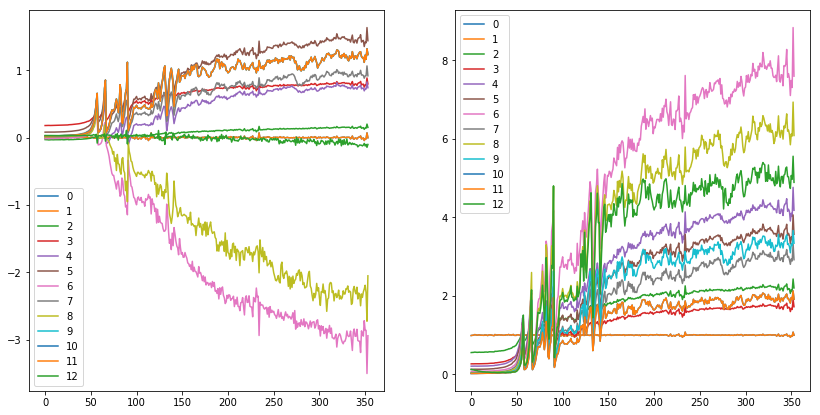

In [247]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))

for l in model.means: ax1.plot(l)
ax1.legend(range(len(model.means)))

# Note to self: model refactoring in additional notebook also helps to cut number of top-level children to 6 and make these more readbable
for l in model.stds: ax2.plot(l)
ax2.legend(range(len(model.stds)))

train: [1.8830384375, tensor(0.3664, device='cuda:0')]
valid: [1.2243623046875, tensor(0.5981, device='cuda:0')]
train: [0.39654859375, tensor(0.8766, device='cuda:0')]
valid: [0.1956843505859375, tensor(0.9400, device='cuda:0')]
train: [0.2000430078125, tensor(0.9378, device='cuda:0')]
valid: [0.13487994384765625, tensor(0.9606, device='cuda:0')]


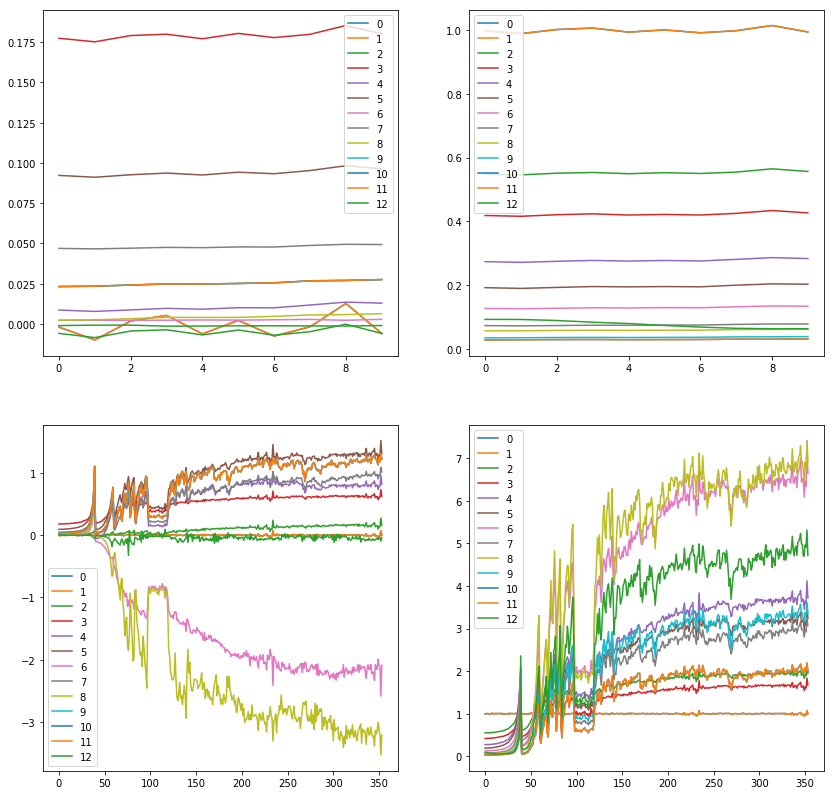

In [248]:
class StatsHook():
  def __init__(self):
    self.means = []
    self.stds = []

  def hook(self, module, input, output):
    self.means.append(output.mean())
    self.stds.append(output.std())

class StatsHooks():
  def __init__(self, layers):
    self.hooks = []
    self.handles = []
    self.layers = layers
    
  def __enter__(self):
    for layer in self.layers:
      hook = StatsHook();
      handle = layer.register_forward_hook(hook.hook)
      self.handles.append(handle)
      self.hooks.append(hook)
    return self
      
  def __exit__(self, exc_type, exc_value, tb):
    import traceback
    if exc_type is not None:
        traceback.print_exception(exc_type, exc_value, tb)
    for handle in self.handles:
      handle.remove()
    self.handles = []

  def __del__(self):
    self.hooks = []
      
model = get_my_model()
opt = optim.SGD(model.parameters(), lr = 0.4)
learner = Learner(model, opt, loss_func, data)

cbfs = [Recorder(), AvgStatsCallback(accuracy), CudaCallback()]
runner = Runner(cbfs)

with StatsHooks(model.layers) as hooks:
  runner.fit(3, learner)
  
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(14,14))

  legend = range(len(hooks.hooks))
  for h in hooks.hooks: ax1.plot(h.means[:10])
  ax1.legend(legend)

  for h in hooks.hooks: ax2.plot(h.stds[:10])
  ax2.legend(legend)
  
  for h in hooks.hooks: ax3.plot(h.means)
  ax3.legend(legend)

  for h in hooks.hooks: ax4.plot(h.stds)
  ax4.legend(legend)

In [249]:
class HookHandler():
  def __init__(self, layers, hook_func):
    self.hooks = []
    self.handles = []
    self.layers = layers
    self.hook_func = hook_func
    
  def __enter__(self):
    for layer in self.layers:
      hook = self.hook_func()
      handle = layer.register_forward_hook(hook)
      self.handles.append(handle)
      self.hooks.append(hook)

    return self
      
  def __exit__(self, exc_type, exc_value, tb):
    import traceback
    if exc_type is not None:
        traceback.print_exception(exc_type, exc_value, tb)
    for handle in self.handles:
      handle.remove()
    self.handles = []

  def __del__(self):
    self.hooks = []
      
model = get_my_model()
opt = optim.SGD(model.parameters(), lr = 0.4)
learner = Learner(model, opt, loss_func, data)

cbfs = [Recorder(), AvgStatsCallback(accuracy), CudaCallback()]
runner = Runner(cbfs)

class HistHook():
  def __init__(self):
    self.hists = []
  
  def __call__(self, module, input, output):
    output = output.clone().cpu()
    self.hists.append(torch.histc(output, bins=100, min=-10, max=10))

with HookHandler(model.layers, HistHook) as hooks:
  runner.fit(1, learner)

  
#   fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(14,14))

#   legend = range(len(hooks.hooks))
#   for h in hooks.hooks: ax1.plot(h.means[:10])
#   ax1.legend(legend)

#   for h in hooks.hooks: ax2.plot(h.stds[:10])
#   ax2.legend(legend)
  
#   for h in hooks.hooks: ax3.plot(h.means)
#   ax3.legend(legend)

#   for h in hooks.hooks: ax4.plot(h.stds)
#   ax4.legend(legend)

train: [2.093138125, tensor(0.2565, device='cuda:0')]
valid: [0.9546478515625, tensor(0.7335, device='cuda:0')]


In [250]:
hist_series = hooks.hooks[4].hists
len(hist_series)

118

In [251]:
hist_series = torch.stack(hist_series).t()
hist_series.shape

torch.Size([100, 118])

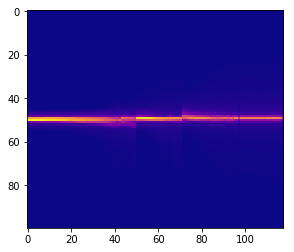

In [252]:
# ssible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_...
plt.imshow(hist_series, cmap='plasma')

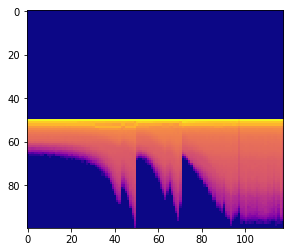

In [253]:
# Note to self: log-transforms rock
hist_series = hooks.hooks[3].hists
hist_series = torch.stack(hist_series).t().log1p()
plt.imshow(hist_series, cmap='plasma')

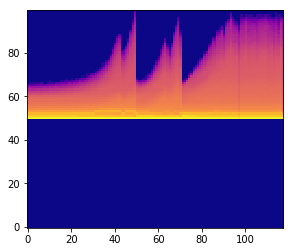

In [254]:
hist_series = hooks.hooks[3].hists
hist_series = torch.stack(hist_series).t().log1p()
# Note to self: was upside-down without origin - ReLU only allow positive values to pass
plt.imshow(hist_series, cmap='plasma', origin='lower')

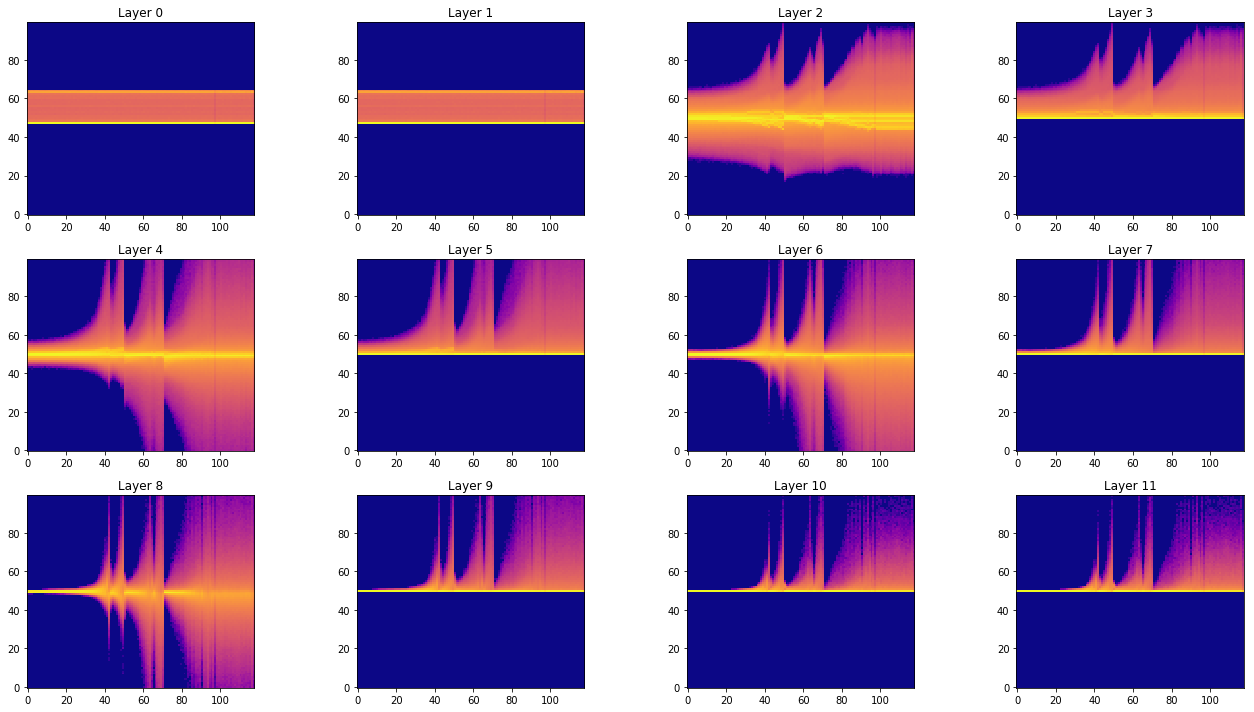

In [255]:
fig, axz = plt.subplots(3, 4, figsize=(20,10))
for hook, ax, idx in zip(hooks.hooks, axz.flatten(), range(len(hooks.hooks))):
  hist_series = hook.hists
  hist_series = torch.stack(hist_series).t().log1p()
  ax.imshow(hist_series, cmap='plasma', origin='lower')
  ax.set_title(f'Layer {idx}')
  fig.tight_layout()

In [256]:
class HistHook():
  def __init__(self, min=-10, max=10, bins=50):
    self.hists = []
    self.bins = bins
    self.min = min
    self.max = max
  
  def __call__(self, module, input, output):
    output = output.clone().cpu()
    self.hists.append(torch.histc(output, bins=self.bins, min=self.min, max=self.max))
    
  def plot_percentage_withinbounds(self, min_bound, max_bound, ax=None):
    data = self.percentage_within_bounds(min_bound, max_bound)
    if not ax: ax = plt.subplot()
    ax.set_ylim(0, 1)
    ax.plot(data)

  def total_percentage_within_bounds(self, min_bound, max_bound):
    all_hists_sum = torch.stack(self.hists).sum()
    selected_bins_series = self._series_bins_between(min_bound, max_bound)
    selected_bins_sum = selected_bins_series.sum()
    return (selected_bins_sum / all_hists_sum.float()).item()
  
  def percentage_within_bounds(self, min_bound, max_bound):
    selected_bins_series = self._series_bins_between(min_bound, max_bound)
    all_hists = torch.stack(self.hists).t()
    return (selected_bins_series.sum(0).float() / all_hists.sum(dim=0).float()).squeeze(0)

  def _series_bins_between(self, min_bound, max_bound):
    assert min_bound < max_bound
    assert min_bound >= self.min
    assert max_bound <= self.max

    assert len(self.hists) > 0
    
    bin_width = (self.max-self.min) / self.bins
    right_bounds = self.min + torch.zeros(self.bins).fill_(bin_width).cumsum(dim=0)
    left_bounds = right_bounds - bin_width

    indexes = (left_bounds >= min_bound)*(right_bounds <= max_bound)
    assert (indexes > 0).any().item(), f"Too narrow of a range, no bins fully selected (single bin is {bin_width})"
    all_hists = torch.stack(self.hists).t()
    return all_hists[indexes]

hook = HistHook()
hook.hists = hooks.hooks[4].hists
hook.bins = 100
hook.total_percentage_within_bounds(-0.4, 0.4), hook.percentage_within_bounds(-0.4, 0.4).shape

(0.6328071355819702, torch.Size([118]))

In [0]:
def test_exception_raised(tested_func, expected_class):
  try:
    tested_func()
    raise Exception(f"Expected {expected_class} to be thrown")
  except Exception as e:
    if not isinstance(e, expected_class):
      raise

    return e

test_exception_raised(lambda: hook.plot_percentage_withinbounds(1, 0), AssertionError)
test_exception_raised(lambda: hook.plot_percentage_withinbounds(0, 0), AssertionError)
test_exception_raised(lambda: hook.plot_percentage_withinbounds(0, 11), AssertionError)
test_exception_raised(lambda: hook.plot_percentage_withinbounds(0, 0.00001), AssertionError)

hook = HistHook(min=0, max=10, bins=10)
hook.hists = [torch.tensor([0,0,0,0,1,1,0,0,0,0])]
test_eq(0,   hook.total_percentage_within_bounds(0, 1))
test_eq(0,   hook.total_percentage_within_bounds(3, 4))
test_eq(0.5, hook.total_percentage_within_bounds(4, 5))
test_eq(0.5, hook.total_percentage_within_bounds(5, 6))
test_eq(1,   hook.total_percentage_within_bounds(4, 6))

hook = HistHook(min=0, max=10, bins=10)
hook.hists = [torch.tensor([0,0,0,0,1,1,0,0,0,0]),
              torch.tensor([0,0,0,0,0,1,1,0,0,0])]
test_eq([0.5,   0], list(hook.percentage_within_bounds(4, 5).numpy()))
test_eq([0.5, 0.5], list(hook.percentage_within_bounds(5, 6).numpy()))
test_eq([0,   0.5], list(hook.percentage_within_bounds(6, 7).numpy()))

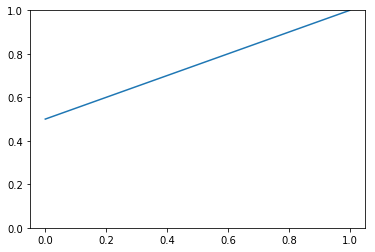

In [258]:
hook.plot_percentage_withinbounds(5, 7)

In [259]:
model = get_my_model()
opt = optim.SGD(model.parameters(), lr = 0.4)
learner = Learner(model, opt, loss_func, data)

cbfs = [Recorder(), AvgStatsCallback(accuracy), CudaCallback()]
runner = Runner(cbfs)

with HookHandler(model.layers, lambda: HistHook(bins=200)) as hooks:
  runner.fit(3, learner) 

train: [1.77542875, tensor(0.3999, device='cuda:0')]
valid: [0.722234130859375, tensor(0.7565, device='cuda:0')]
train: [0.3467409375, tensor(0.8947, device='cuda:0')]
valid: [0.20035201416015624, tensor(0.9381, device='cuda:0')]
train: [0.18005533203125, tensor(0.9450, device='cuda:0')]
valid: [0.15871927490234375, tensor(0.9544, device='cuda:0')]


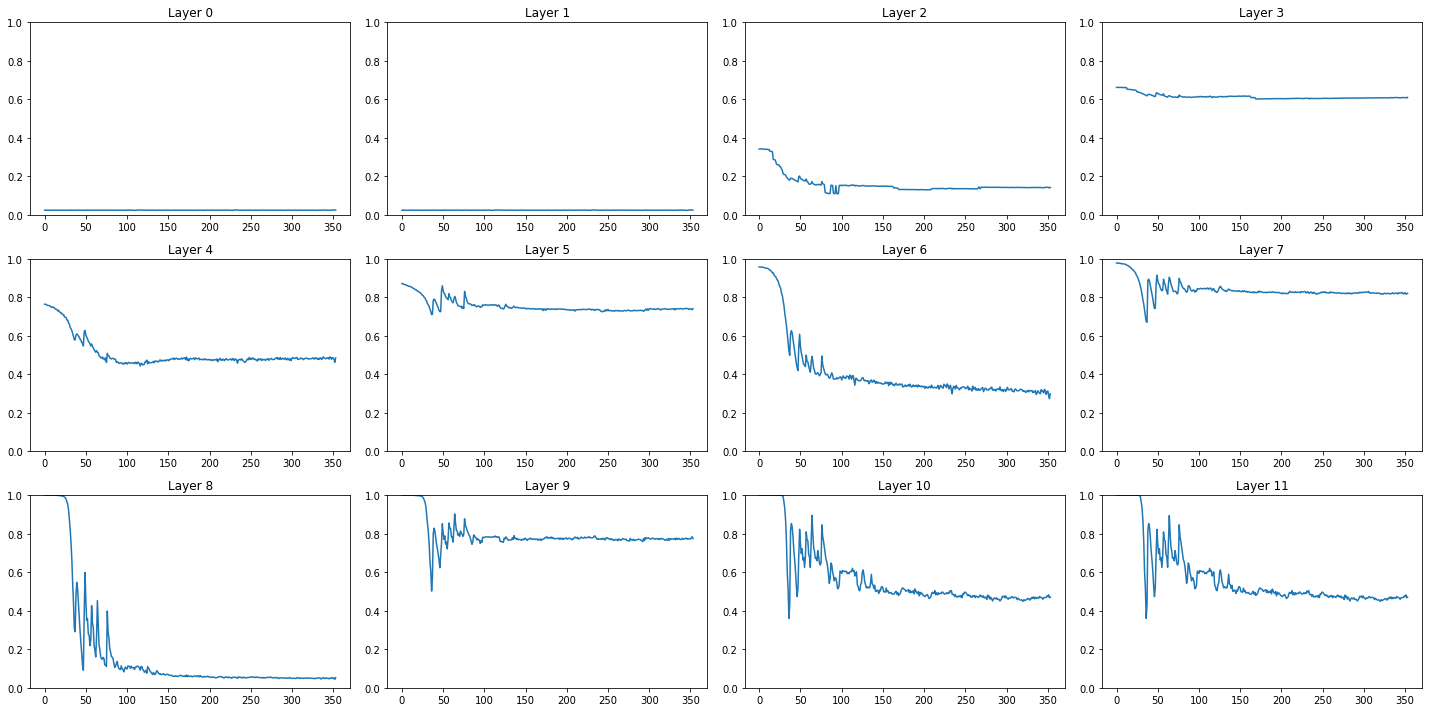

In [260]:
def draw_activations_around_zero(hist_hooks_list):
  fig, axz = plt.subplots(3, 4, figsize=(20,10))
  # Note to self: this graph differs from the original one when -0.1,0.1 used mostly because there's 4x bins out there, so -0.4,0.4 is being drawn and that has more stuff
  for hook, ax, idx in zip(hist_hooks_list, axz.flatten(), range(len(hooks.hooks))):
    ax.set_title(f'Layer {idx}')
    hook.plot_percentage_withinbounds(-0.4, 0.4, ax=ax)
    fig.tight_layout()

draw_activations_around_zero(hooks.hooks)

In [261]:
model = get_my_model()
opt = optim.SGD(model.parameters(), lr = 0.4)
learner = Learner(model, opt, loss_func, data)

cbfs = [Recorder(), AvgStatsCallback(accuracy), CudaCallback()]
runner = Runner(cbfs)

with HookHandler(model.layers, lambda: HistHook(bins=200)) as hooks:
  runner.fit(3, learner) 

train: [1.78589828125, tensor(0.4139, device='cuda:0')]
valid: [0.63838466796875, tensor(0.8023, device='cuda:0')]
train: [0.3336048046875, tensor(0.8997, device='cuda:0')]
valid: [0.1682623779296875, tensor(0.9487, device='cuda:0')]
train: [0.16845091796875, tensor(0.9495, device='cuda:0')]
valid: [0.138625341796875, tensor(0.9561, device='cuda:0')]


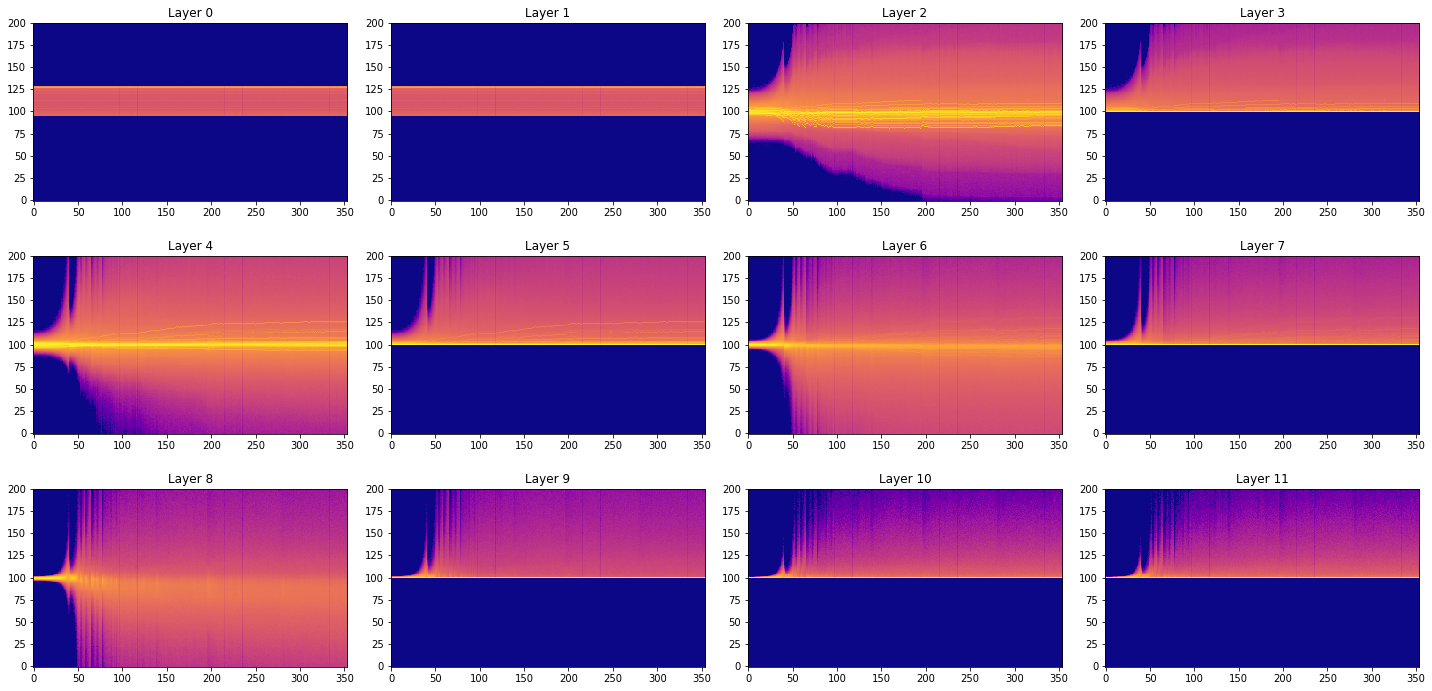

In [262]:
def draw_activation_hists(hist_hooks_list):
  fig, axz = plt.subplots(3, 4, figsize=(20,10))
  for hook, ax, idx in zip(hist_hooks_list, axz.flatten(), range(len(hooks.hooks))):
    hist_series = hook.hists
    hist_series = torch.stack(hist_series).t().log1p()
    ax.imshow(hist_series, cmap='plasma', origin='lower')
    ax.set_title(f'Layer {idx}')
    fig.tight_layout()

draw_activation_hists(hooks.hooks)

train: [1.039035546875, tensor(0.6700, device='cuda:0')]
valid: [0.219008740234375, tensor(0.9357, device='cuda:0')]
train: [0.24993435546875, tensor(0.9232, device='cuda:0')]
valid: [0.1613145751953125, tensor(0.9519, device='cuda:0')]
train: [0.130422783203125, tensor(0.9593, device='cuda:0')]
valid: [0.1054341552734375, tensor(0.9702, device='cuda:0')]


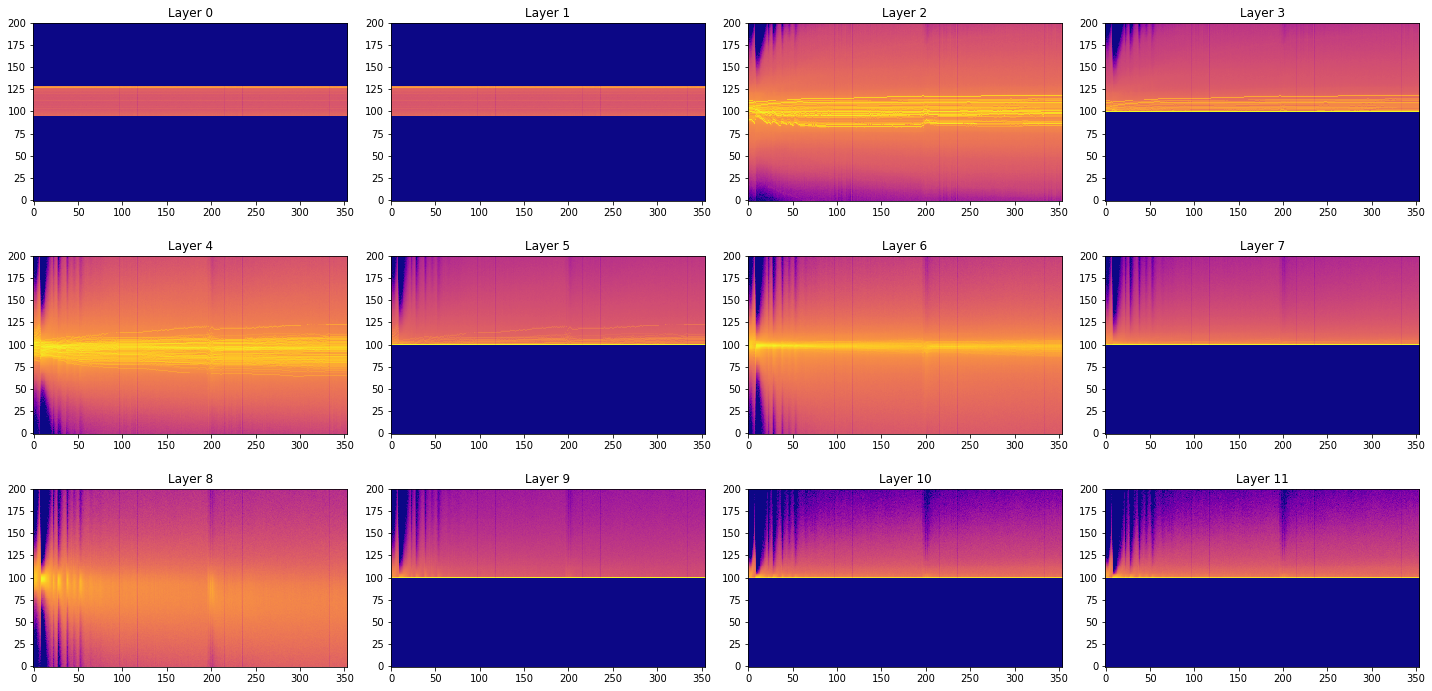

In [263]:
model = get_my_model()
for layer in model.layers:
  if not isinstance(layer, nn.Conv2d):
    continue

  init.kaiming_uniform_(layer.weight, a=0)
  layer.bias.data.zero_()

opt = optim.SGD(model.parameters(), lr = 0.4)
learner = Learner(model, opt, loss_func, data)

cbfs = [Recorder(), AvgStatsCallback(accuracy), CudaCallback()]
runner = Runner(cbfs)

"""Note to self: compare this with loss from default init
train: [2.15812171875, tensor(0.2250, device='cuda:0')]
valid: [1.37014072265625, tensor(0.5338, device='cuda:0')]
train: [0.7518884375, tensor(0.7614, device='cuda:0')]
valid: [0.302093212890625, tensor(0.9100, device='cuda:0')]
train: [0.24640603515625, tensor(0.9271, device='cuda:0')]
valid: [0.16958944091796874, tensor(0.9504, device='cuda:0')]"""
with HookHandler(model.layers, lambda: HistHook(bins=200)) as hooks:
  runner.fit(3, learner)
  
draw_activation_hists(hooks.hooks)

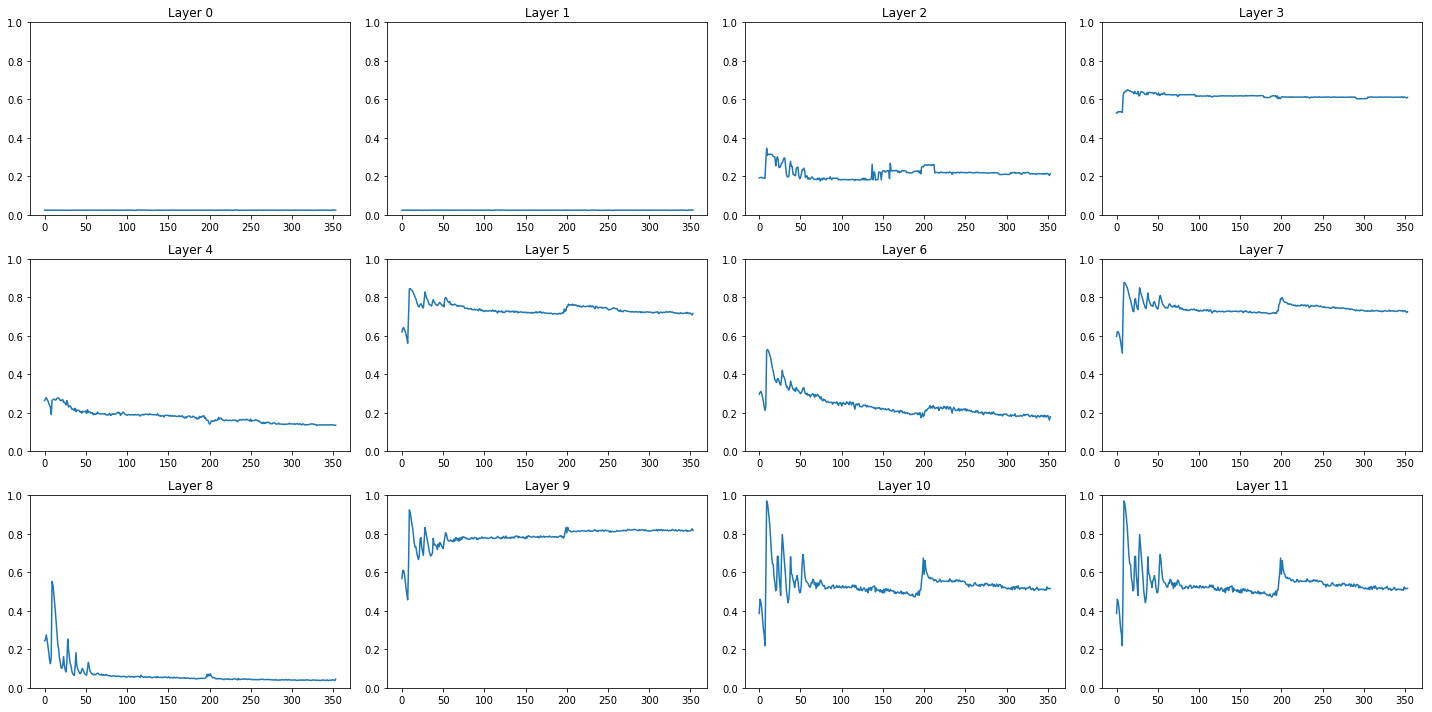

In [264]:
draw_activations_around_zero(hooks.hooks)

In [265]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Lambda()
    (1): Lambda()
    (2): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): AdaptiveAvgPool2d(output_size=1)
    (11): Lambda()
    (12): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [0]:
class GeReLU(nn.Module):
  def __init__(self, max_value=6, negative_slope=0.1, post_shift=-0.4):
    super().__init__()
    self.max_value = max_value
    self.negative_slope = negative_slope
    self.post_shift = post_shift
  
  def forward(self, x):
    x = torch.clamp_max(x, self.max_value)
    x[(x < 0)] = x[(x < 0)] * self.negative_slope
    return x + self.post_shift

test_eq(tensor(1),      GeReLU(max_value=6, post_shift=0)        (tensor(1)))
test_eq(tensor(6),      GeReLU(max_value=6, post_shift=0)        (tensor(11)))
test_near(tensor(-1.2), GeReLU(negative_slope=0.2, post_shift=0) (tensor(-6.)))
test_near(tensor(0.2),  GeReLU(post_shift=0.2)                   (tensor(0.)))
test_near(tensor(0.9),  GeReLU(post_shift=-0.1)                  (tensor(1.)))

In [267]:
slope = 0.1
layers = [GeReLU(negative_slope=slope) if isinstance(l, nn.ReLU) else l for l in get_layers()]
for layer in layers:
  if not isinstance(layer, nn.Conv2d):
    continue

  init.kaiming_uniform_(layer.weight, a=slope)
  layer.bias.data.zero_()
  
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Lambda()
    (1): Lambda()
    (2): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): GeReLU()
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): GeReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): GeReLU()
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): GeReLU()
    (10): AdaptiveAvgPool2d(output_size=1)
    (11): Lambda()
    (12): Linear(in_features=32, out_features=10, bias=True)
  )
)

train: [0.5859927734375, tensor(0.8251, device='cuda:0')]
valid: [0.1991763427734375, tensor(0.9451, device='cuda:0')]
train: [0.1846401953125, tensor(0.9454, device='cuda:0')]
valid: [0.13968394775390625, tensor(0.9604, device='cuda:0')]
train: [0.13401078125, tensor(0.9603, device='cuda:0')]
valid: [0.13566676025390625, tensor(0.9592, device='cuda:0')]


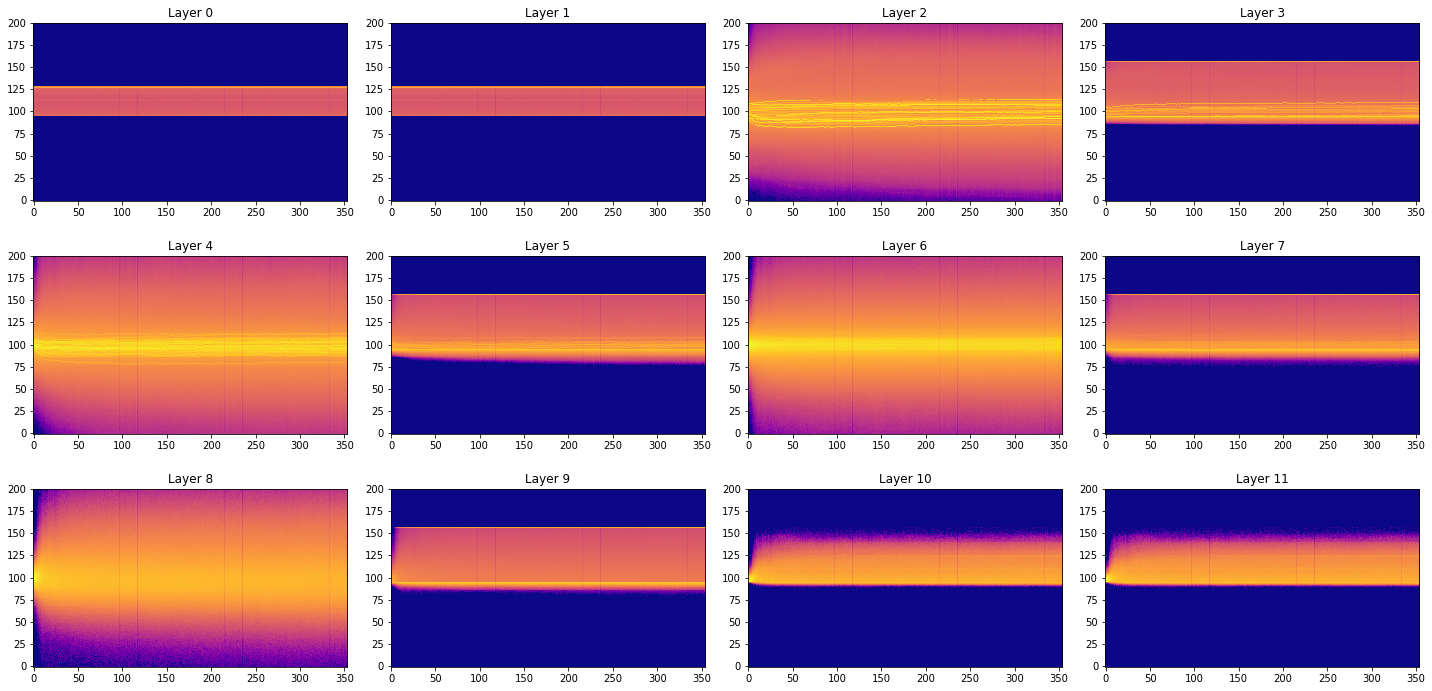

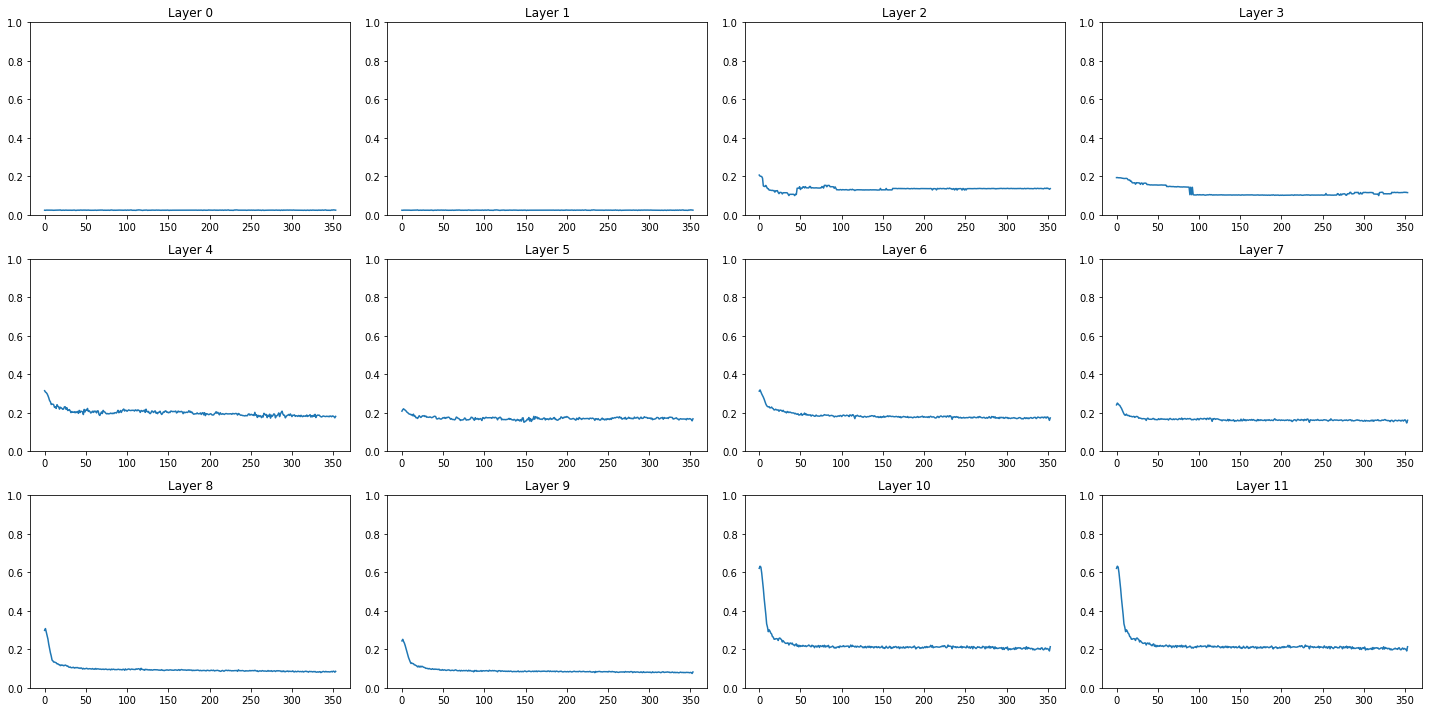

In [268]:
opt = optim.SGD(model.parameters(), lr = 0.4)
learner = Learner(model, opt, loss_func, data)

cbfs = [Recorder(), AvgStatsCallback(accuracy), CudaCallback()]
runner = Runner(cbfs)
""" Note to self: this got to a similar result, moved quicker in the first few epochs
train: [1.150150859375, tensor(0.6370, device='cuda:0')]
valid: [0.260330419921875, tensor(0.9234, device='cuda:0')]
train: [0.229194140625, tensor(0.9312, device='cuda:0')]
valid: [0.15177747802734376, tensor(0.9531, device='cuda:0')]
train: [0.1294714453125, tensor(0.9607, device='cuda:0')]
valid: [0.1033684326171875, tensor(0.9689, device='cuda:0')]
"""
with HookHandler(model.layers, lambda: HistHook(bins=200)) as hooks:
  runner.fit(3, learner)
  
draw_activation_hists(hooks.hooks)
draw_activations_around_zero(hooks.hooks)

In [0]:
pip install wandb -q

W&B Run: https://app.wandb.ai/soboleiv/fastai-p2-v3-l10-cnn/runs/1e9pwlkw
Call `%%wandb` in the cell containing your training loop to display live results.
train: [1.0600446875, tensor(0.6623, device='cuda:0')]
valid: [0.2510710205078125, tensor(0.9280, device='cuda:0')]
train: [0.21888439453125, tensor(0.9353, device='cuda:0')]
valid: [0.14244317626953126, tensor(0.9568, device='cuda:0')]
train: [0.20873263671875, tensor(0.9404, device='cuda:0')]
valid: [0.11496666259765626, tensor(0.9670, device='cuda:0')]


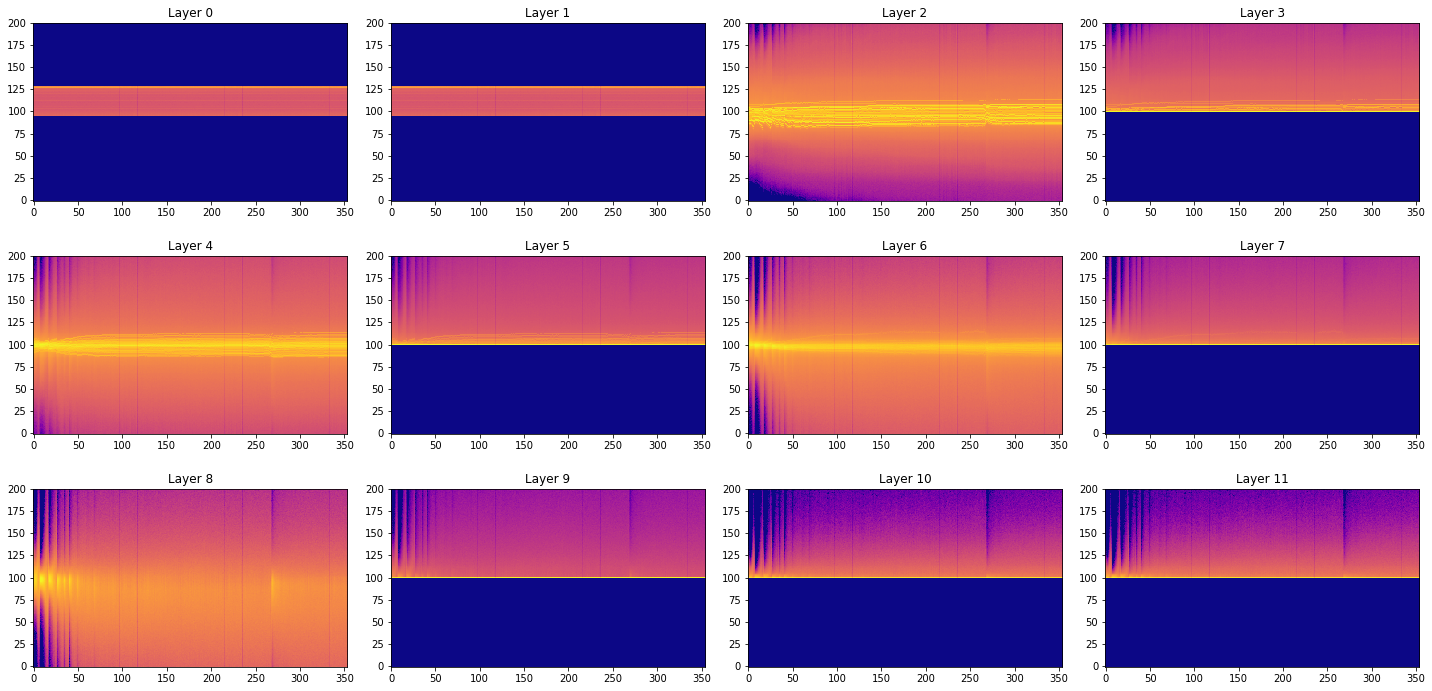

In [270]:
%%wandb
import wandb                                     # <---
wandb.init(project="fastai-p2-v3-l10-cnn")       # <---

# Note to self: this is workaround, only 1 model can be watched per process = bummer for notebooks experimentation
# metrics got recorded, no live monitoring worked in the cell (probably because of the hack + rerun)
wandb.watch_called = False
model = get_my_model()

wandb.watch(model)                               # <---

class WandbStatsCallback(Callback):
  def after_loss(self):
    prefix = 'trn_' if self.in_train else 'valid_'
    wandb.log({'epoch': self.run.epoch, f'{prefix}loss': self.loss.item()})

for layer in model.layers:
  if not isinstance(layer, nn.Conv2d):
    continue

  init.kaiming_uniform_(layer.weight, a=0)
  layer.bias.data.zero_()

opt = optim.SGD(model.parameters(), lr = 0.4)
learner = Learner(model, opt, loss_func, data)

cbfs = [Recorder(), AvgStatsCallback(accuracy), CudaCallback(), WandbStatsCallback()]
runner = Runner(cbfs)

with HookHandler(model.layers, lambda: HistHook(bins=200)) as hooks:
  runner.fit(3, learner)
  
draw_activation_hists(hooks.hooks)

In [0]:
# AttributeError: module 'tensorflow._api.v1.summary' has no attribute 'create_file_writer'
!pip install -q tf-nightly-2.0-preview

In [272]:
%load_ext tensorboard.notebook

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


In [273]:
%tensorboard --logdir logs/tensorboard

W0410 02:00:21.262584 139692756072320 manager.py:322] invalid info file: '/tmp/.tensorboard-info/pid-562.info'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/manager.py", line 317, in get_all
    info = _info_from_string(contents)
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/manager.py", line 158, in _info_from_string
    raise ValueError("incompatible version: %r" % (json_value,))
ValueError: incompatible version: {'cache_key': 'eyJhcmd1bWVudHMiOlsiLS1sb2dkaXIiLCJsb2dzL3RlbnNvcmJvYXJkIl0sImNvbmZpZ3VyZV9rd2FyZ3MiOnt9LCJ3b3JraW5nX2RpcmVjdG9yeSI6Ii9jb250ZW50In0=', 'db': '', 'logdir': 'logs/tensorboard', 'path_prefix': '', 'pid': 562, 'port': 6006, 'start_time': 1554854311, 'version': '1.13.1'}
W0410 02:00:21.825304 139692756072320 manager.py:322] invalid info file: '/tmp/.tensorboard-info/pid-562.info'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/manager.py", line 317, in get_all

In [274]:
import importlib
importlib.reload(summary)

<module 'tensorflow._api.v1.summary' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v1/summary/__init__.py'>

In [275]:
import datetime
from tensorflow import summary
current_time = str(datetime.datetime.now().timestamp())
train_log_dir = 'logs/tensorboard/train/' + current_time
test_log_dir = 'logs/tensorboard/test/' + current_time
train_summary_writer = summary.create_file_writer(train_log_dir)
test_summary_writer = summary.create_file_writer(test_log_dir)

AttributeError: ignored

In [0]:
#      with train_summary_writer.as_default():
#          tf.summary.scalar('loss', loss.item(), step=globaliter)
# https://medium.com/looka-engineering/how-to-use-tensorboard-with-pytorch-in-google-colab-1f76a938bc34

In [0]:
# CNN
# cuda callback
# refactor repeated blocks
# __call__ for between layer hooks collecting mean/std
# plots for the captured stuff for each of the 6 layers, plt.legend
# pytorch hooks
# Hook class, __del__
# ListCointainer
# Hooks(ListContainer), contextmgr
# plot 1st 10 iterations, all
# histograms for activations
# hist graphs, log1p
# min/max of activations
# biases to zero(we don't have BN, probably a trick for faster initial epochs)
# see what Generalized ReLU looks like (sub=0.4, leak=0.1, maxv=6.)
# ---
# IPythoDisplay Javascript
# Bonus points: tensorboard & wab